In [335]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import TimeSeriesSplit, train_test_split, cross_val_score, RandomizedSearchCV

from sklearn.linear_model import Ridge

from scipy.stats import uniform, randint


In [336]:
file_path = "../data/ubc-pair-grade-data/tableau-dashboard-v2/UBCV"

df = pd.DataFrame()

for year_folder in os.listdir(file_path):
    for file in os.listdir(os.path.join(file_path, year_folder)):
        if file.endswith(".csv"):
            df = pd.concat([df, pd.read_csv(os.path.join(file_path, year_folder, file))])

df.to_csv("../data/ubcv_grades_tableau_v2.csv", index=False)

display(df.head())


,Campus,Year,Session,Subject,Course,Detail,Section,Title,Professor,Reported,...,50-54,55-59,60-63,64-67,68-71,72-75,76-79,80-84,85-89,90-100
0,UBCV,2023,W,PLAN,211,NaN,1,City-Making: A Global Perspective,Kunitomo Kamizaki,75,...,3.0,1.0,2.0,10.0,7.0,12.0,11.0,11.0,10.0,3.0
1,UBCV,2023,W,PLAN,221,NaN,1,City Visuals,Erick Villagomez,76,...,0.0,0.0,0.0,0.0,6.0,6.0,28.0,24.0,7.0,2.0
2,UBCV,2023,W,PLAN,231,NaN,1,Methods of Community Engagement,Andrew Binet,32,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,9.0,18.0
3,UBCV,2023,W,PLAN,321,NaN,1,Indigeneity and the City,Jessica Barudin,58,...,0.0,0.0,2.0,0.0,2.0,1.0,5.0,15.0,13.0,17.0
4,UBCV,2023,W,PLAN,331,NaN,2,The Just City in a Divided World,Maged Senbel,66,...,0.0,0.0,1.0,1.0,3.0,1.0,5.0,27.0,19.0,9.0


In [337]:
df.shape

(22652, 27)

In [338]:
df.describe()

,Year,Course,Reported,Avg,Median,Percentile (25),Percentile (75),High,Low,<50,50-54,55-59,60-63,64-67,68-71,72-75,76-79,80-84,85-89,90-100
count,22652.000000,22652.000000,22652.000000,22652.000000,22652.000000,22652.000000,22652.000000,22652.000000,22652.000000,16559.000000,16362.000000,16445.000000,16600.000000,16841.000000,17283.000000,17846.000000,18285.000000,19447.000000,19344.000000,18919.000000
mean,2022.050503,358.745939,50.250839,81.097972,82.665791,77.339091,86.965191,93.527150,51.742407,2.023733,1.180418,1.463363,1.951325,2.662550,4.025748,5.495517,6.721083,10.778269,9.955283,11.210793
std,0.807131,145.387145,59.917795,7.269207,6.937902,9.236363,5.502243,4.533524,27.911982,6.418394,3.646884,3.740935,4.191143,5.107417,6.762412,7.788667,8.467458,12.329700,11.712289,20.553447
min,2021.000000,1.000000,6.000000,18.300000,20.000000,0.000000,20.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2021.000000,234.000000,17.000000,75.900000,78.000000,71.000000,83.000000,90.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,3.000000,2.000000
50%,2022.000000,364.000000,30.000000,80.800000,82.500000,77.250000,87.000000,94.000000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,4.000000,7.000000,7.000000,6.000000
75%,2023.000000,493.000000,57.000000,86.500000,88.000000,84.000000,91.000000,97.000000,75.000000,1.000000,1.000000,1.000000,2.000000,3.000000,6.000000,8.000000,9.000000,14.000000,12.000000,13.000000
max,2023.000000,769.000000,1643.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,282.000000,123.000000,69.000000,91.000000,121.000000,157.000000,146.000000,152.000000,196.000000,245.000000,1410.000000


In [339]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22652 entries, 0 to 3
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Campus           22652 non-null  object 
 1   Year             22652 non-null  int64  
 2   Session          22652 non-null  object 
 3   Subject          22652 non-null  object 
 4   Course           22652 non-null  int64  
 5   Detail           3699 non-null   object 
 6   Section          22652 non-null  object 
 7   Title            22652 non-null  object 
 8   Professor        22234 non-null  object 
 9   Reported         22652 non-null  int64  
 10  Avg              22652 non-null  float64
 11  Median           22652 non-null  float64
 12  Percentile (25)  22652 non-null  float64
 13  Percentile (75)  22652 non-null  float64
 14  High             22652 non-null  float64
 15  Low              22652 non-null  float64
 16  <50              16559 non-null  float64
 17  50-54            1636

In [340]:
df.isna().sum()

Campus                 0
Year                   0
Session                0
Subject                0
Course                 0
Detail             18953
Section                0
Title                  0
Professor            418
Reported               0
Avg                    0
Median                 0
Percentile (25)        0
Percentile (75)        0
High                   0
Low                    0
<50                 6093
50-54               6290
55-59               6207
60-63               6052
64-67               5811
68-71               5369
72-75               4806
76-79               4367
80-84               3205
85-89               3308
90-100              3733
dtype: int64

In [341]:
df['Year'].value_counts().sort_index()

Year
2021    6835
2022    7838
2023    7979
Name: count, dtype: int64

Text(0.5, 1.0, 'Grade Distribution Across All Courses and Years')

<Figure size 1500x600 with 0 Axes>

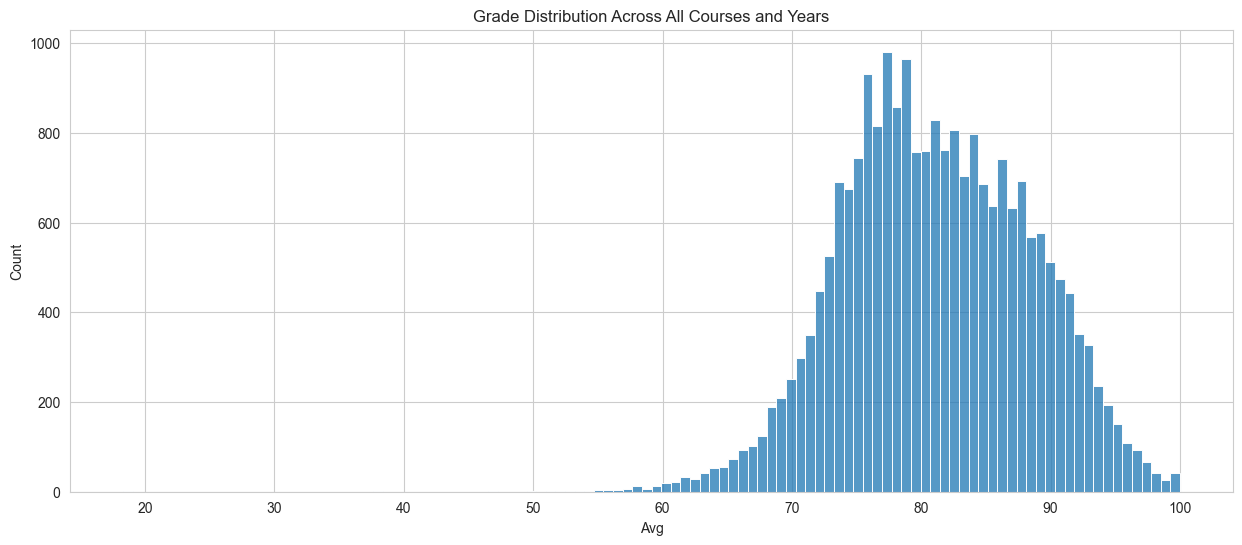

In [342]:
# Overall grade distribution patterns
plt.figure(figsize=(15, 6))

# Distribution of grades
plt.figure(figsize=(15, 6))
sns.histplot(data=df, x='Avg')
plt.title("Grade Distribution Across All Courses and Years")

In [343]:
# Feature engineering
df['SubjectCourse'] = df['Subject'] + df['Course'].astype(str)
df['CourseLevel'] = df['Course'].astype(str).apply(lambda x: x[0])
df['Years_Since_Start'] = df['Year'] - df['Year'].min()
df['Course_Prev_Avg'] = df.groupby('SubjectCourse')['Avg'].shift(1)
df['Course_Historical_Avg'] = df.groupby('SubjectCourse')['Avg'].transform(lambda x: x.shift(1).expanding().mean())

df = df.sort_values(['Year', 'Session'])

previous_stats = ['Avg', 'Median', 'Percentile (25)', 'Percentile (75)', 'High', 'Low',
                 '<50', '50-54', '55-59', '60-63', '64-67', '68-71',
                 '72-75', '76-79', '80-84', '85-89', '90-100']

for stat in previous_stats:
    df[f'Prev_{stat}'] = df.groupby('SubjectCourse')[stat].shift(1)

# Professor's historical statistics
for stat in previous_stats:
    df[f'Prof_Prev_{stat}'] = df.groupby('Professor')[stat].shift(1)  
    
# Professor experience (number of courses taught)
df['Prof_Courses_Taught'] = df.groupby('Professor').cumcount()

display(df)


,Campus,Year,Session,Subject,Course,Detail,Section,Title,Professor,Reported,...,Prof_Prev_55-59,Prof_Prev_60-63,Prof_Prev_64-67,Prof_Prev_68-71,Prof_Prev_72-75,Prof_Prev_76-79,Prof_Prev_80-84,Prof_Prev_85-89,Prof_Prev_90-100,Prof_Courses_Taught
0,UBCV,2021,S,ACAM,390,A,1,Asian Migrations in a Global Context,Henry Yu,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
0,UBCV,2021,S,NEST,304,NaN,951,Ancient Egypt: The Archaeology of the Land of ...,Kevin Fisher,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
0,UBCV,2021,S,IWME,502,NaN,941,Engineering Hydrology,Steven Weijs,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,UBCV,2021,S,IWME,505,NaN,941,Water Resources Systems Planning and Management,Ziad K Shawwash,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
0,UBCV,2021,S,EDCP,325,NaN,951,Approaches to Health Education,Anthony Edwards,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,UBCV,2023,W,RMST,321,NaN,201,French Literature from the Middle Ages to the ...,Patrick Moran,40,...,0.0,0.0,0.0,2.0,4.0,3.0,5.0,12.0,9.0,11.0
8,UBCV,2023,W,RMST,324,NaN,101,Quebecois Literature and Culture,Isabella Huberman,11,...,0.0,0.0,0.0,0.0,4.0,9.0,10.0,10.0,10.0,2.0
9,UBCV,2023,W,RMST,341,NaN,101,Italian Literature and Culture of the Medieval...,Daniela Boccassini,10,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,6.0,3.0,4.0
10,UBCV,2023,W,RMST,345,NaN,101,Italian Fascism in Interdisciplinary Perspective,Carlo Testa,13,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,4.0


In [344]:
# Column types
ordinal_cols = ['CourseLevel', 'Years_Since_Start', 'Prof_Courses_Taught']
categorical_cols = ['Campus', 'Session', 'SubjectCourse', 'Professor']
numeric_cols = ['Year', 'Course_Prev_Avg', 'Course_Historical_Avg']
drop_cols = ['Reported', 'Section', 'Detail', 'Median', 
                'Percentile (25)', 'Percentile (75)', 'High', 'Low',
                '<50', '50-54', '55-59', '60-63', '64-67', '68-71', 
                '72-75', '76-79', '80-84', '85-89', '90-100']

numeric_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', drop='if_binary')
)

ordinal_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
)

preprocessor = make_column_transformer(
    (numeric_pipeline, numeric_cols),
    (categorical_pipeline, categorical_cols),
    (ordinal_pipeline, ordinal_cols),
    ("drop", drop_cols)
)

In [345]:
df = df.sort_values('Year')

split_year = df['Year'].quantile(0.8)
train_df = df[df['Year'] < split_year]
test_df = df[df['Year'] >= split_year]

In [346]:
X_train = train_df.drop(columns=['Avg'])
y_train = train_df['Avg']
X_test = test_df.drop(columns=['Avg'])
y_test = test_df['Avg']

X_train['Section'] = X_train['Section'].astype(str)

display(X_train.head())

,Campus,Year,Session,Subject,Course,Detail,Section,Title,Professor,Reported,...,Prof_Prev_55-59,Prof_Prev_60-63,Prof_Prev_64-67,Prof_Prev_68-71,Prof_Prev_72-75,Prof_Prev_76-79,Prof_Prev_80-84,Prof_Prev_85-89,Prof_Prev_90-100,Prof_Courses_Taught
0,UBCV,2021,S,ACAM,390,A,1,Asian Migrations in a Global Context,Henry Yu,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
8,UBCV,2021,W,EECE,565,NaN,101,Communication Networks,Wai-Shuen Vincent Wong,9,...,NaN,NaN,16.0,11.0,6.0,13.0,7.0,9.0,NaN,2.0
7,UBCV,2021,W,EECE,562,NaN,101,Statistical Signal Processing,Zhen Wang,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,2.0
6,UBCV,2021,W,EECE,560,NaN,201,Network Analysis and Simulation,Jose Marti,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,UBCV,2021,W,EECE,555,NaN,101,Renewable and Efficient Electric Power Systems,Sina Chiniforoosh,21,...,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,1.0


In [347]:
results = {}

rg_pipe = make_pipeline(
    preprocessor,
    Ridge()
)

In [348]:
rg_pipe.fit(X_train, y_train)

results['Ridge'] = [rg_pipe.score(X_train, y_train), cross_val_score(rg_pipe, X_train, y_train, cv=TimeSeriesSplit(n_splits=5)).mean()]

results_df = pd.DataFrame(results, index=['Train Score', 'CV Score'])

display(results_df)

/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: 

,Ridge
Train Score,0.880346
CV Score,0.632683


In [349]:
# Get the feature importances
feature_importances = pd.Series(
    rg_pipe['ridge'].coef_,
    index=rg_pipe['columntransformer'].get_feature_names_out()
)

# Convert to DataFrame and sort
importances_df = pd.DataFrame({
    'Feature': feature_importances.index,
    'Importance': feature_importances.values
})

display(importances_df.sort_values('Importance', ascending=False).head())

,Feature,Importance
7397,pipeline-2__Professor_Kimberly Huyser,10.371644
3729,pipeline-2__SubjectCourse_MUSC169,8.811564
5098,pipeline-2__Professor_Alyssa Alexander,8.386824
9208,pipeline-2__Professor_Tai-Peng Tsai;Patrick Walls,8.348211
7637,pipeline-2__Professor_Louis Maraj,8.283509


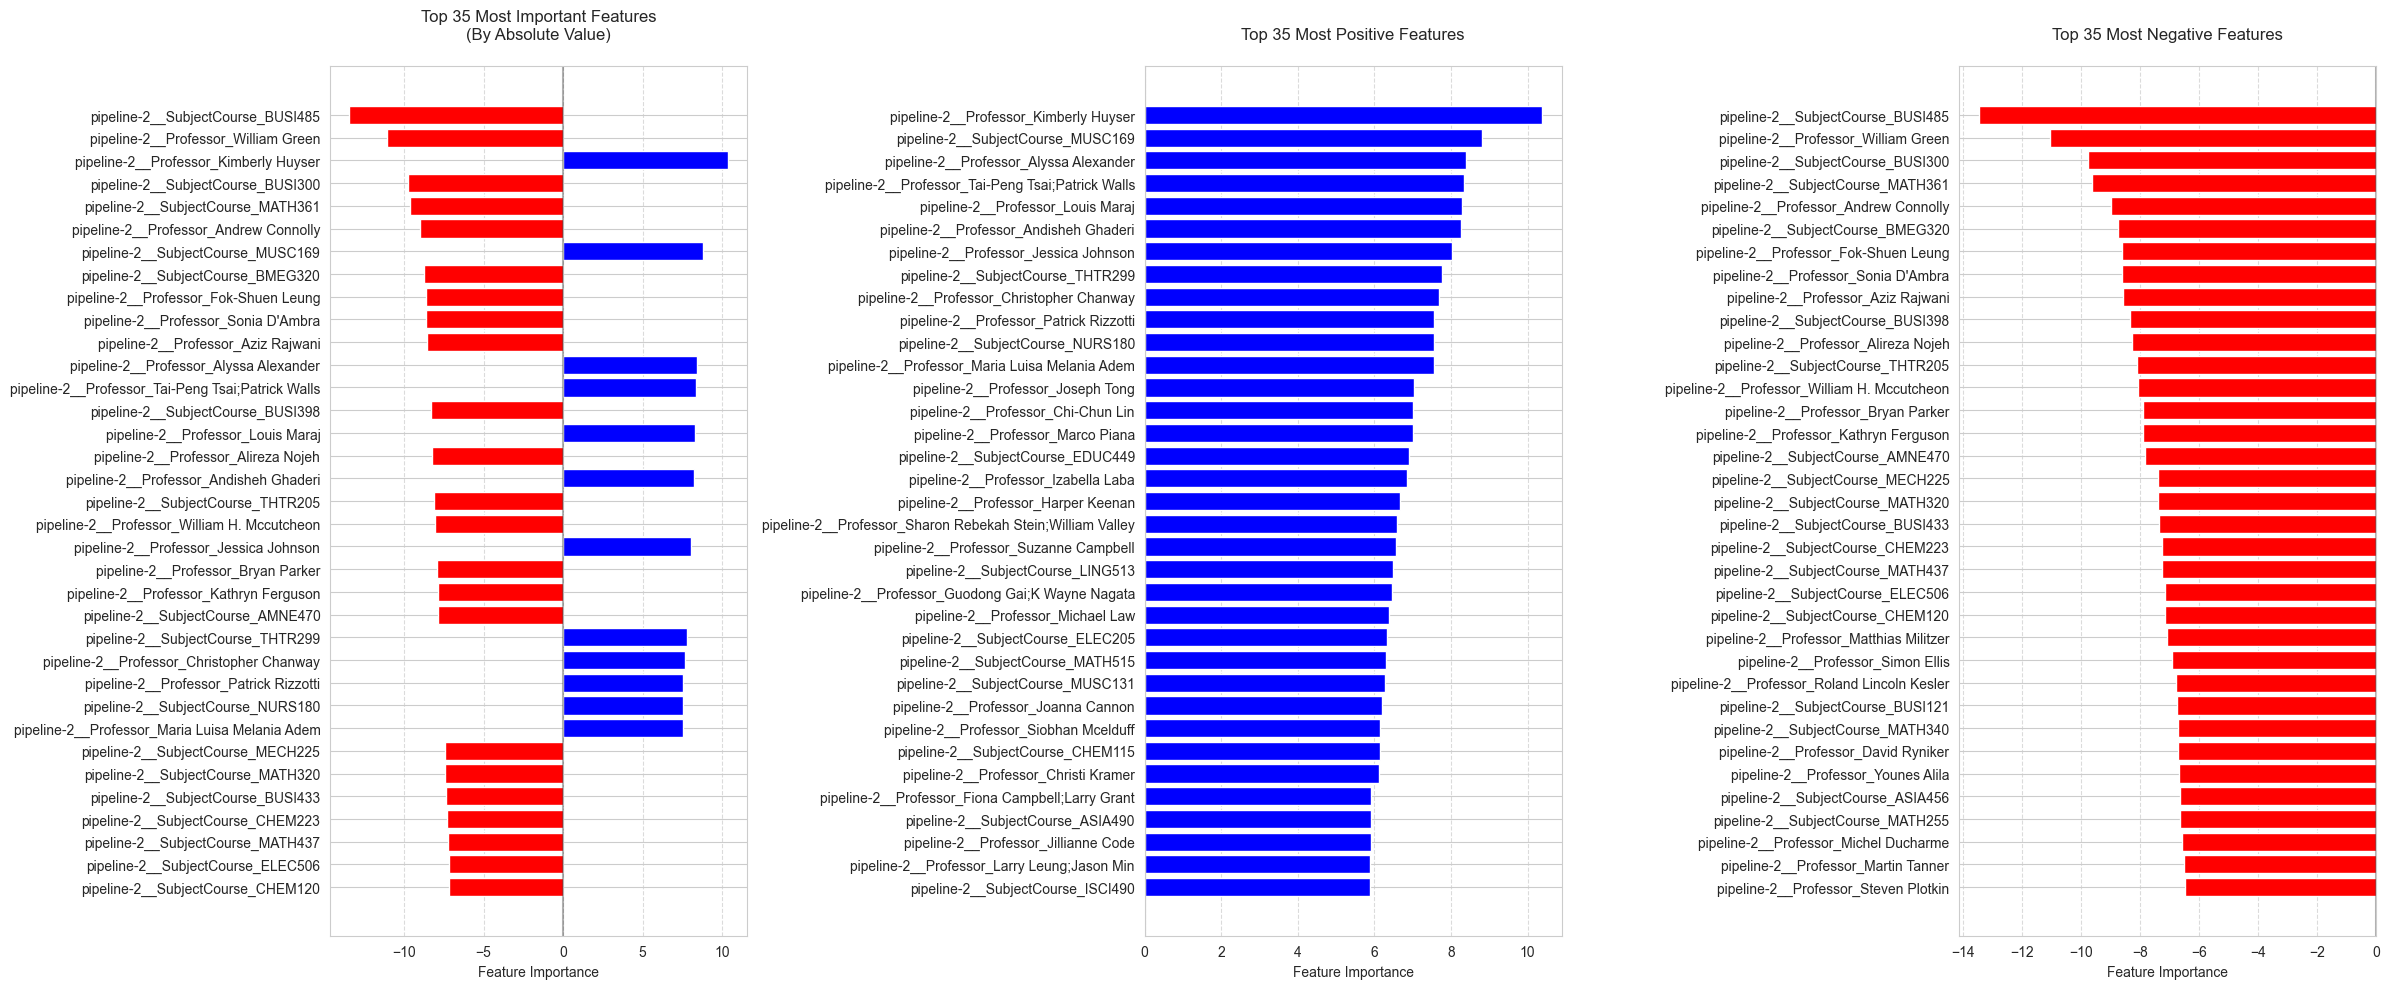

In [350]:
importances_df['Abs_Importance'] = np.abs(importances_df['Importance'])

top_overall = importances_df.sort_values('Abs_Importance', ascending=False).head(35)
top_positive = importances_df[importances_df['Importance'] > 0].sort_values('Importance', ascending=False).head(35)
top_negative = importances_df[importances_df['Importance'] < 0].sort_values('Importance').head(35)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 10))

# Plot 1: Overall most important
colors1 = ['red' if x < 0 else 'blue' for x in top_overall['Importance']]
ax1.barh(top_overall['Feature'], top_overall['Importance'], color=colors1)
ax1.set_title('Top 35 Most Important Features\n(By Absolute Value)', pad=20)
ax1.set_xlabel('Feature Importance')
ax1.invert_yaxis()
ax1.grid(axis='x', linestyle='--', alpha=0.7)
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Plot 2: Top positive features
ax2.barh(top_positive['Feature'], top_positive['Importance'], color='blue')
ax2.set_title('Top 35 Most Positive Features', pad=20)
ax2.set_xlabel('Feature Importance')
ax2.invert_yaxis()
ax2.grid(axis='x', linestyle='--', alpha=0.7)
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Plot 3: Top negative features
ax3.barh(top_negative['Feature'], top_negative['Importance'], color='red')
ax3.set_title('Top 35 Most Negative Features', pad=20)
ax3.set_xlabel('Feature Importance')
ax3.invert_yaxis()
ax3.grid(axis='x', linestyle='--', alpha=0.7)
ax3.axvline(x=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

In [355]:
rg_pipe.score(X_test, y_test)

/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.5298606168053156